In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import anderson, shapiro, norm
import scipy.stats as stats
import math
#import ace_tools as tools


## Load Canadian CPI Timeseries Data

In [2]:
df = pd.read_csv("../data/processed/Canada_CPI_Processed_2018_2019.csv")

In [3]:
print(df)

      Products and product groups    REF_DATE  VALUE
0              Air transportation  2017-01-01  134.8
1              Air transportation  2017-02-01  135.2
2              Air transportation  2017-03-01  133.7
3              Air transportation  2017-04-01  134.7
4              Air transportation  2017-05-01  139.4
...                           ...         ...    ...
10261            Wooden furniture  2019-10-01   94.5
10262            Wooden furniture  2019-11-01   96.8
10263            Wooden furniture  2019-12-01   96.8
10264            Wooden furniture  2020-01-01   94.4
10265            Wooden furniture  2020-02-01   94.4

[10266 rows x 3 columns]


In [4]:
# Create a filtered copy by excluding rows where 'Product_Service' starts with "All" or "Other" as those are groups of products
df = df[~df["Products and product groups"].str.startswith(("All", "Other"))].copy()

In [5]:
print(df)

      Products and product groups    REF_DATE  VALUE
0              Air transportation  2017-01-01  134.8
1              Air transportation  2017-02-01  135.2
2              Air transportation  2017-03-01  133.7
3              Air transportation  2017-04-01  134.7
4              Air transportation  2017-05-01  139.4
...                           ...         ...    ...
10261            Wooden furniture  2019-10-01   94.5
10262            Wooden furniture  2019-11-01   96.8
10263            Wooden furniture  2019-12-01   96.8
10264            Wooden furniture  2020-01-01   94.4
10265            Wooden furniture  2020-02-01   94.4

[8646 rows x 3 columns]


In [6]:
df = df.rename(columns={"Products and product groups": "Product_Service"})
df["REF_DATE"] = pd.to_datetime(df["REF_DATE"])

## Add Product Category to the CPI Timeseries Dataframe

In [7]:
# Add category to the dataframe
df_categories = pd.read_csv("../data/processed/CAN_Categorized_Products_and_Services_NEW.csv")

# Merging df with df_categories on 'Product_Service'
df = df_categories.merge(df, on='Product_Service', how='inner')

# Reordering columns
df = df[['Category', 'Product_Service', 'REF_DATE', 'VALUE']]

# Display the new DataFrame
print(df)


      Category                                    Product_Service   REF_DATE  \
0          ???                                      Durable goods 2017-01-01   
1          ???                                      Durable goods 2017-02-01   
2          ???                                      Durable goods 2017-03-01   
3          ???                                      Durable goods 2017-04-01   
4          ???                                      Durable goods 2017-05-01   
...        ...                                                ...        ...   
8641  Vehicles  Recreational equipment and services (excluding... 2019-10-01   
8642  Vehicles  Recreational equipment and services (excluding... 2019-11-01   
8643  Vehicles  Recreational equipment and services (excluding... 2019-12-01   
8644  Vehicles  Recreational equipment and services (excluding... 2020-01-01   
8645  Vehicles  Recreational equipment and services (excluding... 2020-02-01   

          VALUE  
0     93.115385  
1  

In [8]:
print(df)

      Category                                    Product_Service   REF_DATE  \
0          ???                                      Durable goods 2017-01-01   
1          ???                                      Durable goods 2017-02-01   
2          ???                                      Durable goods 2017-03-01   
3          ???                                      Durable goods 2017-04-01   
4          ???                                      Durable goods 2017-05-01   
...        ...                                                ...        ...   
8641  Vehicles  Recreational equipment and services (excluding... 2019-10-01   
8642  Vehicles  Recreational equipment and services (excluding... 2019-11-01   
8643  Vehicles  Recreational equipment and services (excluding... 2019-12-01   
8644  Vehicles  Recreational equipment and services (excluding... 2020-01-01   
8645  Vehicles  Recreational equipment and services (excluding... 2020-02-01   

          VALUE  
0     93.115385  
1  

## Run Anderson-Darling test at the Category level

In [9]:
# Function to test normality using Anderson-Darling test
def test_normality(series):
    result = anderson(series.dropna(), dist='norm')
    return result.statistic, result.critical_values, result.significance_level

# Group by Category and apply normality test
results = []
for category, group in df.groupby("Category"):
    stat, crit_values, sig_levels = test_normality(group["VALUE"])
    
    # Find the significance level where statistic < critical value
    normality = any(stat < cv for cv in crit_values)
    
    results.append({
        "Category": category,
        "Test_Statistic": stat,
        "Normal_Anderson_Darling?": normality
    })

# Convert to DataFrame and display
results_df_AD_cat = pd.DataFrame(results)
#tools.display_dataframe_to_user(name="Normality Test Results", dataframe=results_df_AD_cat)
print(results_df_AD_cat)

                           Category  Test_Statistic  Normal_Anderson_Darling?
0                               ???        8.894931                     False
1                 Alcohol & Tobacco       32.675443                     False
2            Appliances & Equipment       58.690592                     False
3        Clothing & Footwear Groups       18.444199                     False
4             Clothing and footwear       31.275784                     False
5                     Communication        9.962530                     False
6               Education & Reading        9.150408                     False
7                            Energy        1.116688                     False
8            Furniture & Home Decor       44.997763                     False
9                         Gardening        1.906746                     False
10                        Groceries        7.904024                     False
11           Health & Personal Care       12.550687             

In [10]:
# Function to test normality using Shapiro-Wilk test
def test_normality(series):
    if len(series) < 3:  # Shapiro-Wilk requires at least 3 data points
        return np.nan, np.nan
    stat, p_value = shapiro(series.dropna())
    return stat, p_value

# Group by Product_Service and apply normality test
results = []
for category, group in df.groupby("Category"):
    stat, p_value = test_normality(group["VALUE"])
    
    # A p-value > 0.05 means we fail to reject normality (data is likely normal)
    normality = p_value > 0.05

    results.append({
        "Category": category,
        "Test_Statistic": stat,
        "P_Value": p_value,
        "Normal_Shapiro_Wilk?": normality
    })

# Convert results to DataFrame and display
results_df_SW_cat = pd.DataFrame(results)

# Display the results
#tools.display_dataframe_to_user(name="Shapiro-Wilk Normality Test Results", dataframe=results_df_SW)
print(results_df_SW_cat)

                           Category  Test_Statistic       P_Value  \
0                               ???        0.917433  1.472087e-11   
1                 Alcohol & Tobacco        0.815181  1.697532e-22   
2            Appliances & Equipment        0.732713  2.081972e-27   
3        Clothing & Footwear Groups        0.791618  3.493793e-15   
4             Clothing and footwear        0.834781  3.082056e-22   
5                     Communication        0.841574  1.601272e-11   
6               Education & Reading        0.937744  8.796515e-11   
7                            Energy        0.969212  9.906273e-03   
8            Furniture & Home Decor        0.665877  6.450391e-25   
9                         Gardening        0.886273  1.067972e-03   
10                        Groceries        0.991798  2.916987e-11   
11           Health & Personal Care        0.937893  1.129930e-14   
12               Household Supplies        0.908272  1.271371e-10   
13              Housing & Utilitie

In [11]:
# Merging result of both tests (Shapiro-Wilk and Andersen-Darling) in one dataframe so that results could be compared side by side
results_df_SW_AD_cat = results_df_SW_cat.merge(results_df_AD_cat, on='Category', how='inner')

# Reordering columns
results_df_SW_AD_cat = results_df_SW_AD_cat[['Category', 'Normal_Shapiro_Wilk?', 'Normal_Anderson_Darling?']]

# Display the new DataFrame
print(results_df_SW_AD_cat)

                           Category  Normal_Shapiro_Wilk?  \
0                               ???                 False   
1                 Alcohol & Tobacco                 False   
2            Appliances & Equipment                 False   
3        Clothing & Footwear Groups                 False   
4             Clothing and footwear                 False   
5                     Communication                 False   
6               Education & Reading                 False   
7                            Energy                 False   
8            Furniture & Home Decor                 False   
9                         Gardening                 False   
10                        Groceries                 False   
11           Health & Personal Care                 False   
12               Household Supplies                 False   
13              Housing & Utilities                 False   
14  Housing, Rent, Tax  & Insurance                 False   
15       Recreation & En

## Plot Normalization distribution curve for all categories

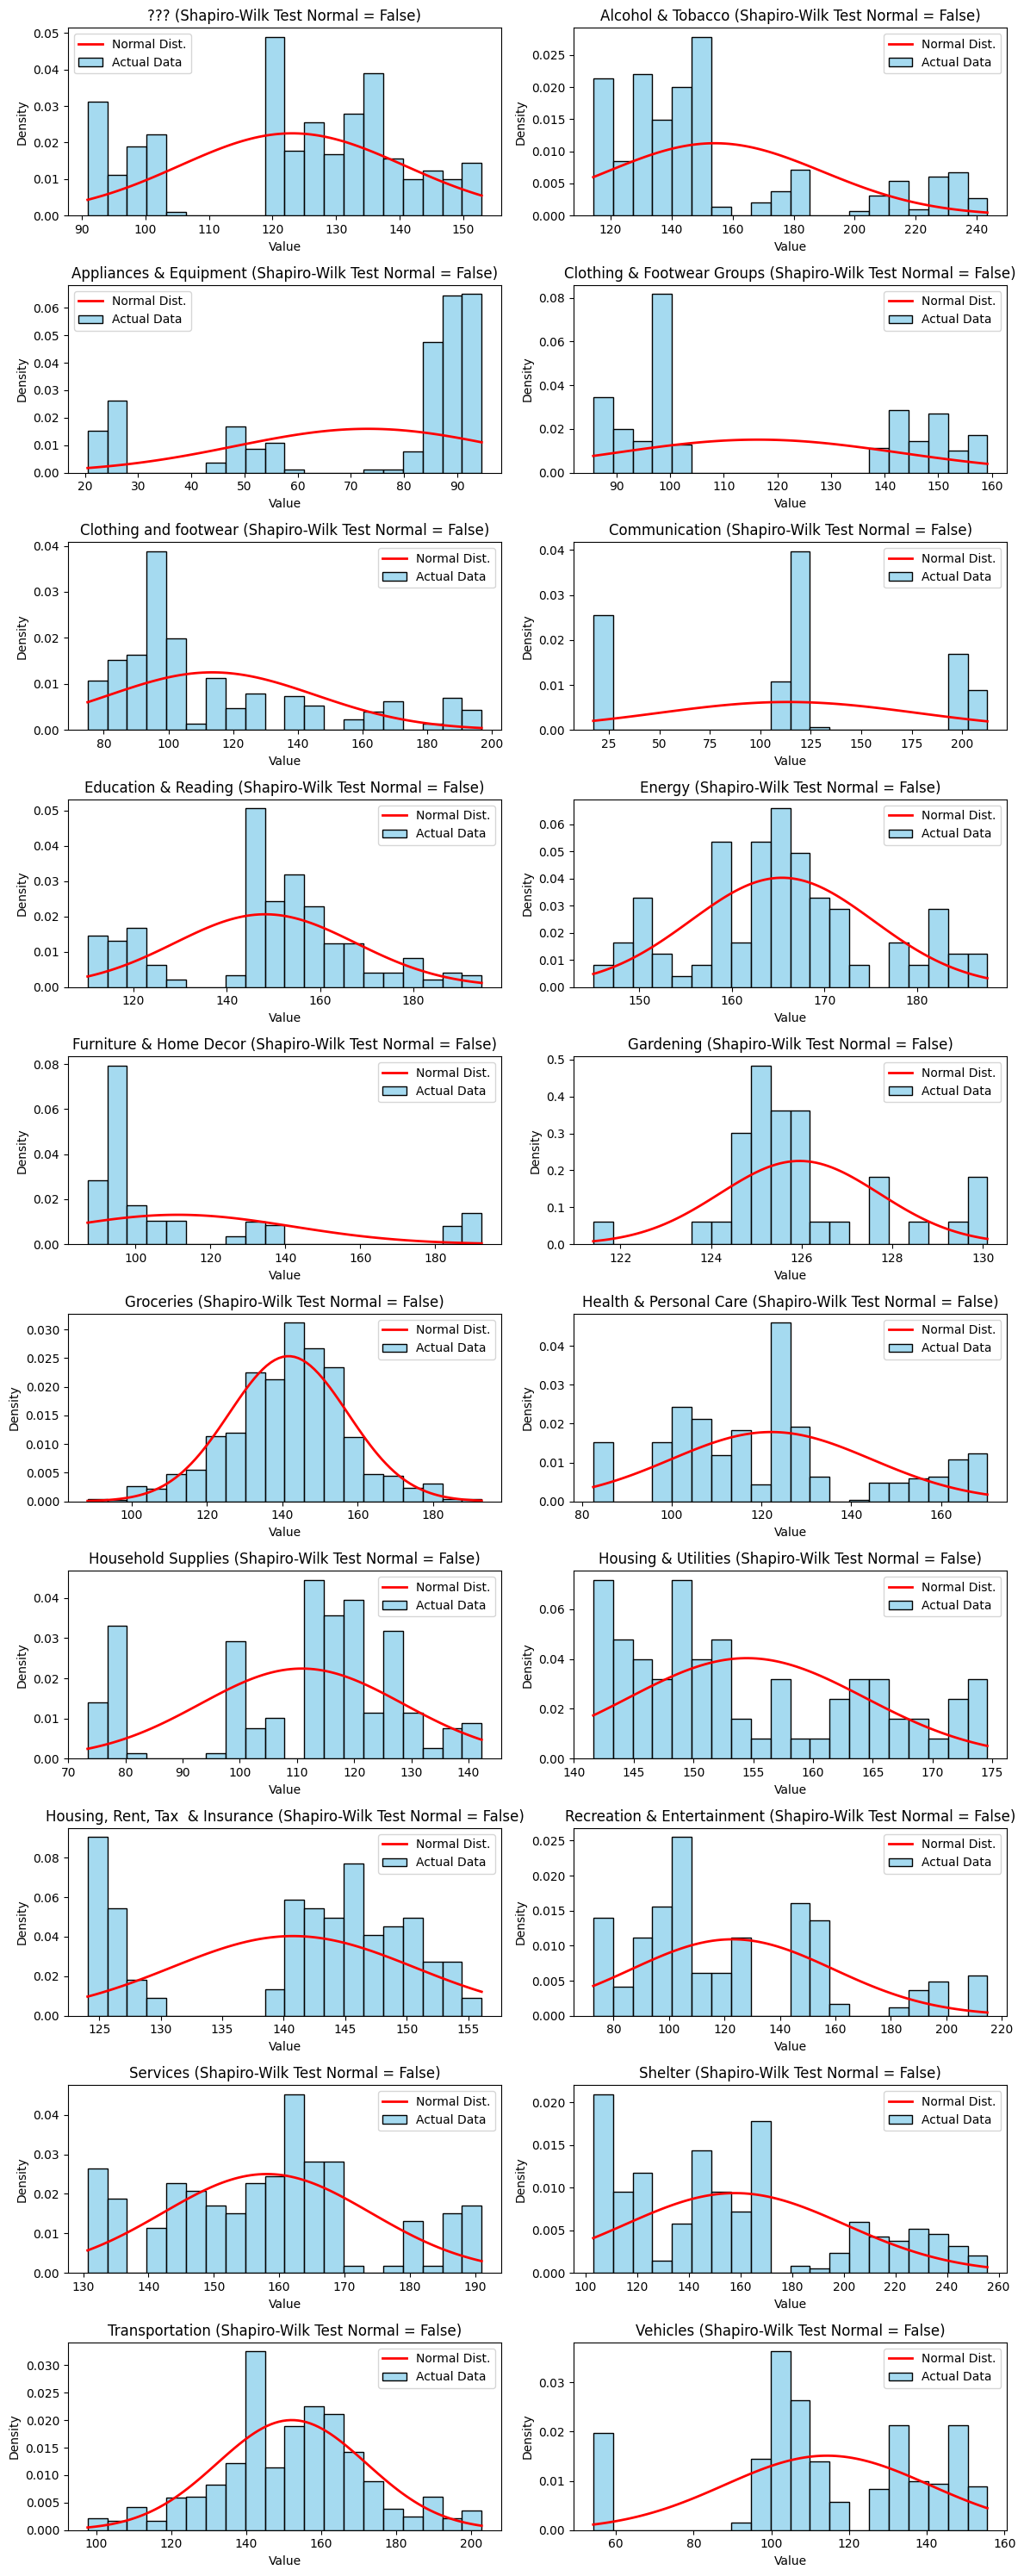

In [12]:
#Plot normal distributions for all Categories

# Extract the Category values into a list
timeseries_to_plot = df["Category"].unique().tolist()

# Number of rows and columns for subplots
num_plots = len(timeseries_to_plot)
num_cols = 2  # One plot per row
num_rows = (num_plots + 1) // num_cols  # Calculate needed rows

# Set up the figure with a reduced size
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 3 * num_rows))
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Loop through each time series ID and plot
for i, ts_id in enumerate(timeseries_to_plot):
    ax = axes[i]
    
    # Filter data for the current time series ID
    ts_data = df[df["Category"] == ts_id]["VALUE"].dropna()
    
    # Skip if no data available
    if ts_data.empty:
        ax.set_visible(False)  # Hide empty plots
        continue
    
    # Calculate mean and standard deviation
    mu, sigma = np.mean(ts_data), np.std(ts_data)

    # Generate x values for normal distribution curve
    x = np.linspace(min(ts_data), max(ts_data), 100)
    pdf = norm.pdf(x, mu, sigma)

    # Plot histogram
    sns.histplot(ts_data, bins=20, kde=False, stat="density", color='skyblue', label="Actual Data", ax=ax)

    # Plot normal distribution curve
    ax.plot(x, pdf, color='red', linewidth=2, label="Normal Dist.")

    # Titles and labels
    SW_test_result = results_df_SW_AD_cat.loc[results_df_SW_AD_cat["Category"] == ts_id, "Normal_Shapiro_Wilk?"].values[0]
    ax.set_title(f"{ts_id} (Shapiro-Wilk Test Normal = {SW_test_result})")
    ax.set_xlabel("Value")
    ax.set_ylabel("Density")
    ax.legend()

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

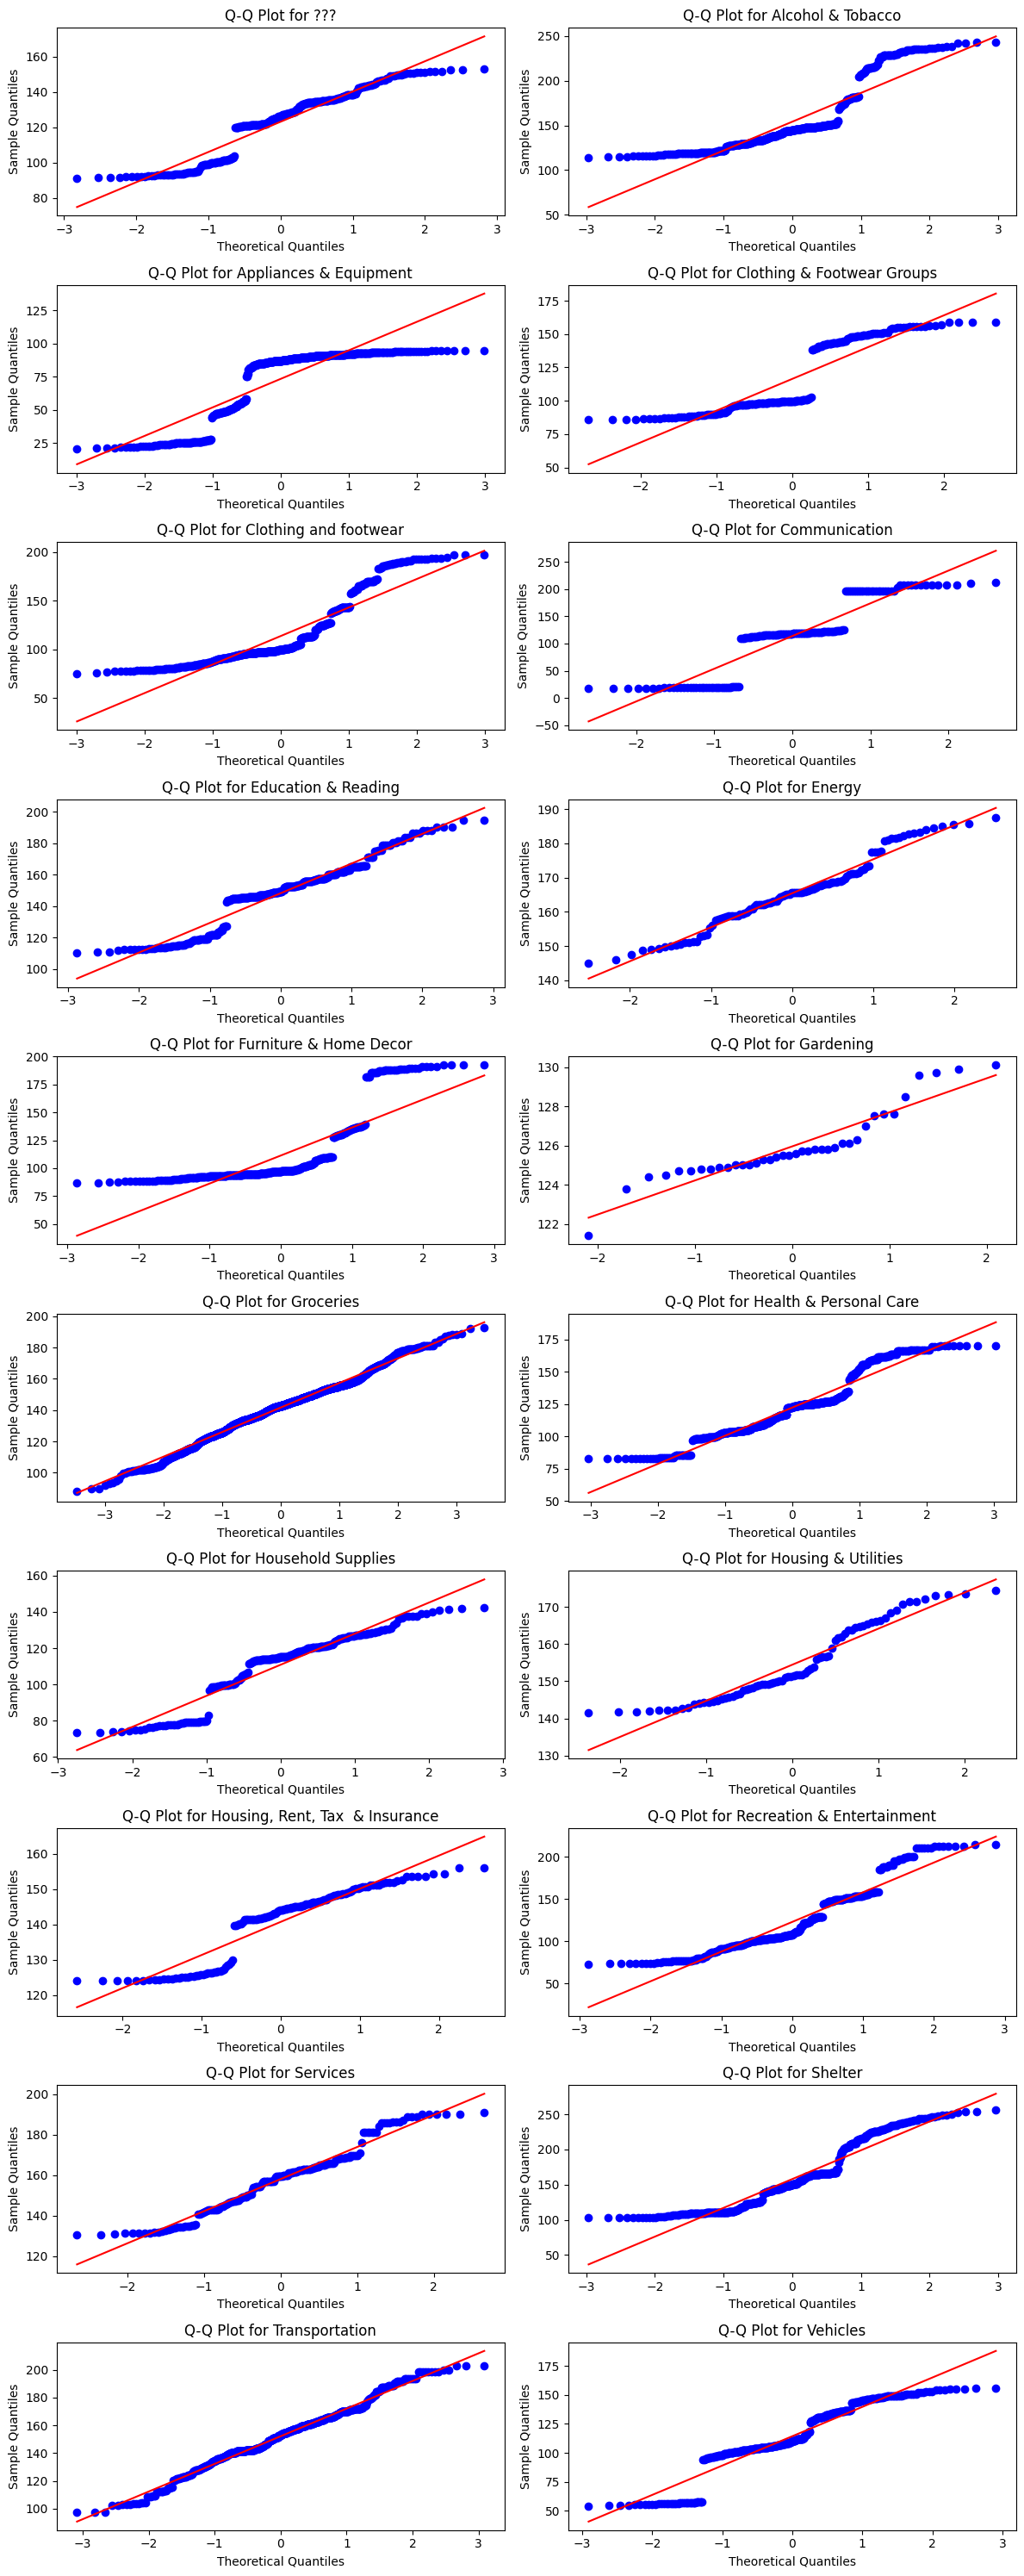

In [13]:
# Number of rows and columns for subplots
num_plots = len(timeseries_to_plot)
num_cols = 2  # Two plots per row
num_rows = (num_plots + 1) // num_cols  # Calculate needed rows

# Set up the figure with reduced height
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 3 * num_rows))  # Adjust height
axes = axes.flatten()  # Flatten axes for easy iteration

# Loop through each time series ID and plot Q-Q plot
for i, ts_id in enumerate(timeseries_to_plot):
    ax = axes[i]
    
    # Filter data for the current time series ID
    ts_data = df[df["Category"] == ts_id]["VALUE"].dropna()
    
    # Skip if no data available
    if ts_data.empty:
        ax.set_visible(False)  # Hide empty plots
        continue
    
    # Q-Q Plot
    stats.probplot(ts_data, dist="norm", plot=ax)
    
    # Titles and labels
    ax.set_title(f"Q-Q Plot for {ts_id}")
    ax.set_xlabel("Theoretical Quantiles")
    ax.set_ylabel("Sample Quantiles")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


## Run Anderson-Darling test at the Individual Product level for all Products

In [14]:
# Function to test normality using Anderson-Darling test
def test_normality(series):
    result = anderson(series.dropna(), dist='norm')
    return result.statistic, result.critical_values, result.significance_level

# Group by Product_Service and apply normality test
results = []
for product, group in df.groupby("Product_Service"):
    stat, crit_values, sig_levels = test_normality(group["VALUE"])
    
    # Find the significance level where statistic < critical value
    normality = any(stat < cv for cv in crit_values)
    
    results.append({
        "Product_Service": product,
        "Test_Statistic": stat,
        "Normal_Anderson_Darling?": normality
    })

# Convert to DataFrame and display
results_df_AD = pd.DataFrame(results)
#tools.display_dataframe_to_user(name="Normality Test Results", dataframe=results_df_AD)
print(results_df_AD)

                                       Product_Service  Test_Statistic  \
0                                   Air transportation        0.841107   
1                                  Alcoholic beverages        0.988301   
2            Alcoholic beverages purchased from stores        0.914652   
3    Alcoholic beverages served in licensed establi...        0.917254   
4    Alcoholic beverages, tobacco products and recr...        1.826129   
..                                                 ...             ...   
224                         Wine purchased from stores        0.802578   
225             Wine served in licensed establishments        2.196359   
226                                   Women's clothing        0.369949   
227              Women's footwear (excluding athletic)        0.933819   
228                                   Wooden furniture        0.772790   

     Normal_Anderson_Darling?  
0                        True  
1                        True  
2              

In [15]:
# Function to test normality using Shapiro-Wilk test
def test_normality(series):
    if len(series) < 3:  # Shapiro-Wilk requires at least 3 data points
        return np.nan, np.nan
    stat, p_value = shapiro(series.dropna())
    return stat, p_value

# Group by Product_Service and apply normality test
results = []
for product, group in df.groupby("Product_Service"):
    stat, p_value = test_normality(group["VALUE"])
    
    # A p-value > 0.05 means we fail to reject normality (data is likely normal)
    normality = p_value > 0.05

    results.append({
        "Product_Service": product,
        "Test_Statistic": stat,
        "P_Value": p_value,
        "Normal_Shapiro_Wilk?": normality
    })

# Convert results to DataFrame and display
results_df_SW = pd.DataFrame(results)

# Display the results
#tools.display_dataframe_to_user(name="Shapiro-Wilk Normality Test Results", dataframe=results_df_SW)
print(results_df_SW)

                                       Product_Service  Test_Statistic  \
0                                   Air transportation        0.925311   
1                                  Alcoholic beverages        0.924099   
2            Alcoholic beverages purchased from stores        0.925592   
3    Alcoholic beverages served in licensed establi...        0.925248   
4    Alcoholic beverages, tobacco products and recr...        0.875566   
..                                                 ...             ...   
224                         Wine purchased from stores        0.936861   
225             Wine served in licensed establishments        0.863822   
226                                   Women's clothing        0.962933   
227              Women's footwear (excluding athletic)        0.901164   
228                                   Wooden furniture        0.950247   

      P_Value  Normal_Shapiro_Wilk?  
0    0.014315                 False  
1    0.013131                 False

In [16]:
# Merging result of both tests (Shapiro-Wilk and Andersen-Darling) in one dataframe so that results could be compared side by side
results_df_SW_AD = results_df_SW.merge(results_df_AD, on='Product_Service', how='inner')

# Reordering columns
results_df_SW_AD = results_df_SW_AD[['Product_Service', 'Normal_Shapiro_Wilk?', 'Normal_Anderson_Darling?']]

# Display the new DataFrame
print(results_df_SW_AD)

                                       Product_Service  Normal_Shapiro_Wilk?  \
0                                   Air transportation                 False   
1                                  Alcoholic beverages                 False   
2            Alcoholic beverages purchased from stores                 False   
3    Alcoholic beverages served in licensed establi...                 False   
4    Alcoholic beverages, tobacco products and recr...                 False   
..                                                 ...                   ...   
224                         Wine purchased from stores                 False   
225             Wine served in licensed establishments                 False   
226                                   Women's clothing                  True   
227              Women's footwear (excluding athletic)                 False   
228                                   Wooden furniture                  True   

     Normal_Anderson_Darling?  
0      

## Filter the records for Products that follow normal distribution 


In [17]:
#Filter the records for Products that follow normal distribution 
filtered_df_normal = results_df_SW_AD[(results_df_SW_AD["Normal_Shapiro_Wilk?"] == True)]

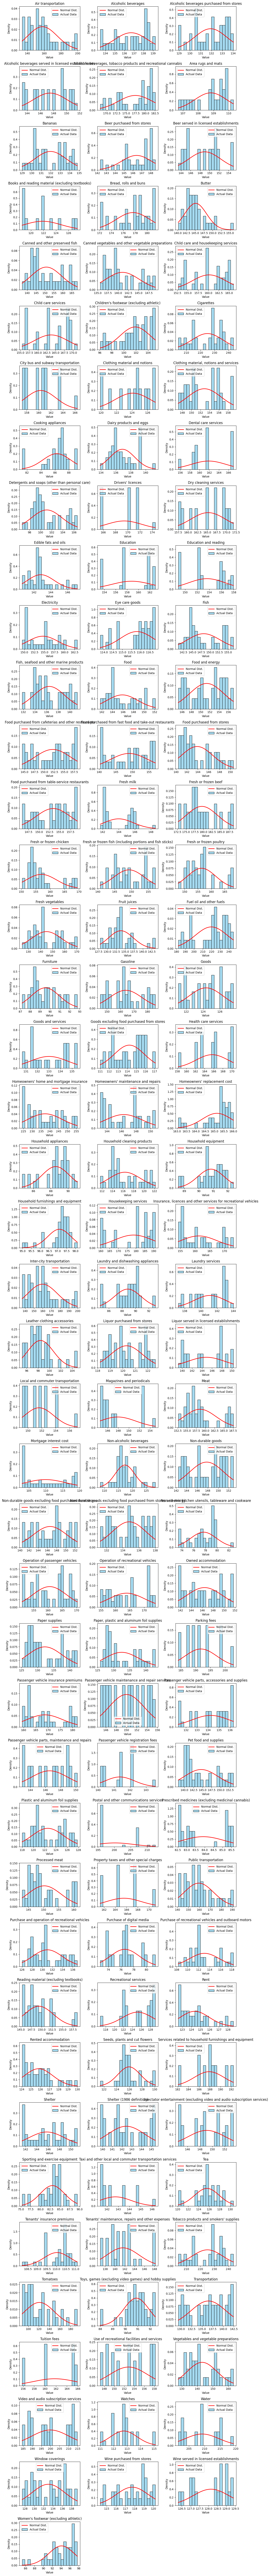

In [18]:
""" Plot normal distributions for Products where Shapiro-Wilk test returns Normal as False
indicating that the data diesn't follow normal distribution """

# Filter the DataFrame for rows where both tests say that the data doesn't follow normal distribution (False)

filtered_df_not_normal = results_df_SW_AD[(results_df_SW_AD["Normal_Shapiro_Wilk?"] == False)]

# Extract the Product_Service values into a list
non_normal_timeseries = filtered_df_not_normal["Product_Service"].tolist()

# Number of rows and columns for subplots
num_plots = len(non_normal_timeseries)
num_cols = 3  # Three plots per row
num_rows = math.ceil(num_plots/num_cols)  # Calculate needed rows

# Set up the figure with a reduced size
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 3 * num_rows))
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Loop through each time series ID and plot
for i, ts_id in enumerate(non_normal_timeseries):
    ax = axes[i]
    
    # Filter data for the current time series ID
    ts_data = df[df["Product_Service"] == ts_id]["VALUE"].dropna()
    
    # Skip if no data available
    if ts_data.empty:
        ax.set_visible(False)  # Hide empty plots
        continue
    
    # Calculate mean and standard deviation
    mu, sigma = np.mean(ts_data), np.std(ts_data)

    # Generate x values for normal distribution curve
    x = np.linspace(min(ts_data), max(ts_data), 100)
    pdf = norm.pdf(x, mu, sigma)

    # Plot histogram
    sns.histplot(ts_data, bins=20, kde=False, stat="density", color='skyblue', label="Actual Data", ax=ax)

    # Plot normal distribution curve
    ax.plot(x, pdf, color='red', linewidth=2, label="Normal Dist.")

    # Titles and labels
    ax.set_title(f"{ts_id}")
    ax.set_xlabel("Value")
    ax.set_ylabel("Density")
    ax.legend()

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


## Rechecking the normality for Category Groceries to confirm normality as the visual distribution looks symmetrical but both the tests  (Shapiro-Wilk and Andersen-Darling) indicate it is not normal

In [19]:
df_can_groceries = df.loc[df["Category"] == "Groceries"]

In [20]:
print(df_can_groceries)

       Category                        Product_Service   REF_DATE       VALUE
2898  Groceries                                 Apples 2017-01-01  132.800000
2899  Groceries                                 Apples 2017-02-01  133.900000
2900  Groceries                                 Apples 2017-03-01  133.500000
2901  Groceries                                 Apples 2017-04-01  136.600000
2902  Groceries                                 Apples 2017-05-01  139.000000
...         ...                                    ...        ...         ...
5591  Groceries  Vegetables and vegetable preparations 2019-10-01  144.376923
5592  Groceries  Vegetables and vegetable preparations 2019-11-01  150.400000
5593  Groceries  Vegetables and vegetable preparations 2019-12-01  152.538462
5594  Groceries  Vegetables and vegetable preparations 2020-01-01  159.576923
5595  Groceries  Vegetables and vegetable preparations 2020-02-01  159.876923

[2698 rows x 4 columns]


In [21]:
stat, p_value = test_normality(df_can_groceries["VALUE"])

In [22]:
# A p-value > 0.05 means we fail to reject normality (data is likely normal)
normality = p_value > 0.05

In [23]:
normality

np.False_

In [24]:
p_value

np.float64(2.9169872505943656e-11)

In [25]:
df_can_groceries.describe()

,REF_DATE,VALUE
count,2698,2698.000000
mean,2018-07-16 23:22:06.315789568,141.644423
min,2017-01-01 00:00:00,88.300000
25%,2017-10-01 00:00:00,132.700000
50%,2018-07-16 12:00:00,142.723077
75%,2019-05-01 00:00:00,151.725000
max,2020-02-01 00:00:00,192.900000
std,NaN,15.748521


Mean: 141.64442321947882, Median: 142.72307692307692
Skewness: -0.1369117344185551, Kurtosis: 3.405937609243419


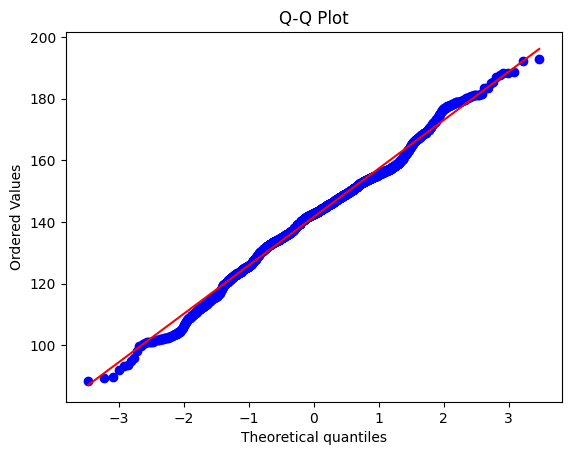

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# Sample Data
data_series = df_can_groceries["VALUE"]

# Calculate Mean & Median
mean_val = np.mean(data_series)
median_val = np.median(data_series)

print(f"Mean: {mean_val}, Median: {median_val}")

# Check Skewness & Kurtosis
skewness = stats.skew(data_series)
kurtosis = stats.kurtosis(data_series) + 3  # Adjusted for normal distribution

print(f"Skewness: {skewness}, Kurtosis: {kurtosis}")

# Q-Q Plot
stats.probplot(data_series, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()


Shapiro-Wilk Test: Statistic=0.9917975080003559, p-value=2.9169872505943656e-11
Anderson-Darling Test: Statistic=7.904023620909356, Critical Values=[0.575 0.655 0.786 0.917 1.09 ]


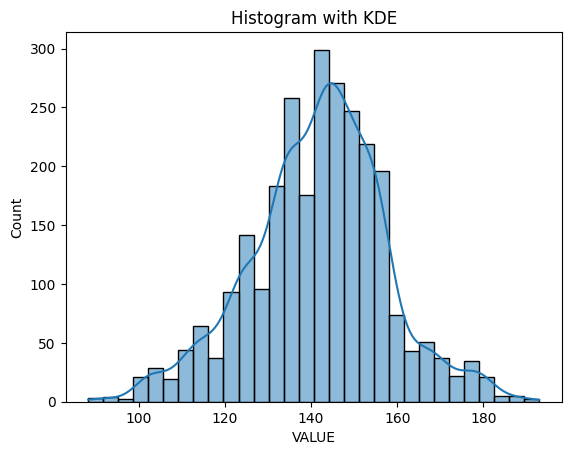

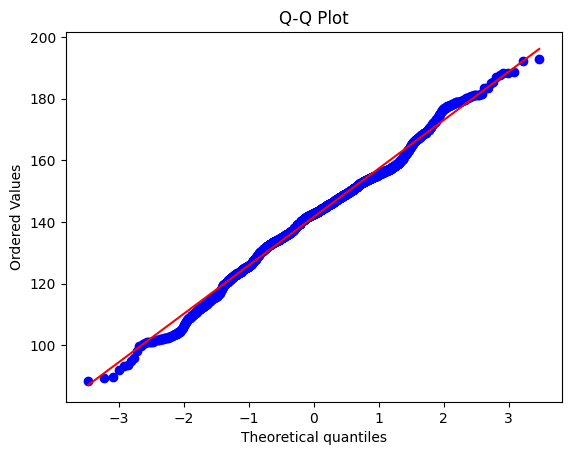

In [27]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Sample Data (Replace with actual dataset)
data_series = df_can_groceries["VALUE"]

# Normality Tests
shapiro_test = stats.shapiro(data_series)
anderson_test = stats.anderson(data_series, dist="norm")

print(f"Shapiro-Wilk Test: Statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue}")
print(f"Anderson-Darling Test: Statistic={anderson_test.statistic}, Critical Values={anderson_test.critical_values}")

# Histogram
sns.histplot(data_series, kde=True, bins=30)
plt.title("Histogram with KDE")
plt.show()

# Q-Q Plot
stats.probplot(data_series, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()
